In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-classification/WELFake_Dataset.csv


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv('/kaggle/input/fake-news-classification/WELFake_Dataset.csv')

# EXTRAPOLARY DATA ANALYSIS

## FAKE=0 REAL=1

In [5]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [7]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [8]:
df.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [9]:
y = df.label
print(f'Ratio of real and fake news:')
y.value_counts(normalize=True).rename({1: 'real', 0: 'fake'})

Ratio of real and fake news:


label
real    0.514404
fake    0.485596
Name: proportion, dtype: float64

**51% of news is real in the datset whereas 49% is fake**

In [10]:
df=df.fillna('')

In [11]:
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

## Analyzing distinction

**First we will look at a few example of fake and real news and analyze their distinction manually and write code which helps us take advantage of their distinction for e.g** 
1. Check if fake news titles are shorter, longer, or more sensational.
2. Engagement Words: Fake news might use words like "shocking," "breaking," or "unbelievable."
3. Readability Metrics: Fake news might have simpler language, spelling errors, or informal tone. Use metrics like Flesch reading ease.
4. Sentiment Analysis: Check if sentiment trends differ (e.g., fake news might use sensational language).
5. Word Frequency Analysis: Identify frequent words or phrases in fake and real news separately. Use tools like CountVectorizer or TfidfVectorizer.

>## Work Cloud ( to distinguish the words used in Fake news)
1. What It Does:
Concatenate Text: Combines all the text entries in the fake_news['text'] column into a single string (fake_text). This provides a consolidated text corpus for fake news.
2. Generate Word Cloud: Uses the WordCloud library to generate a visual representation of the most frequent words in the fake_text. Larger words indicate higher frequency.
3. Display Word Cloud: Displays the word cloud using matplotlib.

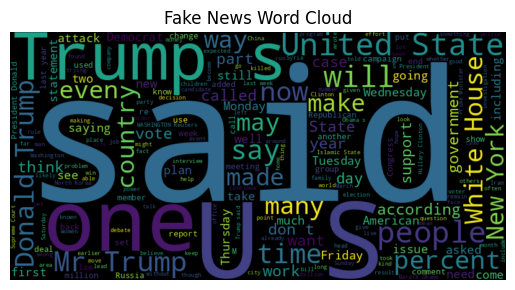

In [12]:

# Separate fake and real news
fake_news = df[df['label'] == 0]
real_news = df[df['label'] == 1]

# Word cloud for fake news
fake_text = ' '.join(fake_news['text'])
wordcloud_fake = WordCloud(width=800, height=400).generate(fake_text)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title("Fake News Word Cloud")
plt.axis('off')
plt.show()

# Word frequency using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_fake = vectorizer.fit_transform(fake_news['text'])
tfidf_real = vectorizer.fit_transform(real_news['text'])

# Topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_fake = lda.fit(tfidf_fake)
lda_real = lda.fit(tfidf_real)


>## Manual inspection of examples

In [13]:
# Get 10 random examples of fake news
fake_news_samples = fake_news.sample(n=10, random_state=42)

# Get 10 random examples of real news
real_news_samples = real_news.sample(n=10, random_state=42)

# Display the samples
print("Fake News Examples:")
print(fake_news_samples)

print("\nReal News Examples:")
print(real_news_samples)


Fake News Examples:
                                                   title  \
42025  Two People Die after Eating Raw-Milk Cheese Ma...   
56304  DUP blames Sinn Fein for Northern Ireland talk...   
23174  Exclusive: Former top Brazil prosecutor says s...   
49262  U.S. intelligence chief says Russia involvemen...   
19935  Macri's coalition poised to win key Argentina ...   
47170  ¿Qué bolá? Obama jokes with Cuban humorist in ...   
21714  Bolton on Susan Rice Scandal: Obama Needs to B...   
39140  Germany not mulling sanctions against U.S. aft...   
53893  NBC News Releases First Promo for ’Sunday Nigh...   
23012  Japan's struggling opposition Democrats pick e...   

                                                    text  label  
42025  Two people have died following an outbreak of ...      0  
56304  BELFAST (Reuters) - A senior member of Norther...      0  
23174  BRASILIA (Reuters) - Three senior Brazilian la...      0  
49262  WASHINGTON (Reuters) - U.S. Director of Nation..

>## Linguistical features
1. Fake news might have simpler language, spelling errors, or informal tone

In [14]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.2 MB/s eta 0:00:00a 0:00:01


In [15]:
import textstat

# Function to calculate readability score for each article
def calculate_readability(df):
    df['flesch_reading_ease'] = df['text'].apply(textstat.flesch_reading_ease)
    return df

# Apply to fake and real news
fake_news = calculate_readability(fake_news)
real_news = calculate_readability(real_news)

# Check average readability scores
print("Fake News Readability Average:", fake_news['flesch_reading_ease'].mean())
print("Real News Readability Average:", real_news['flesch_reading_ease'].mean())


<ipython-input-15-0b4883d18ef8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['flesch_reading_ease'] = df['text'].apply(textstat.flesch_reading_ease)


Fake News Readability Average: 55.145327452323855
Real News Readability Average: 60.93210478089797


<ipython-input-15-0b4883d18ef8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['flesch_reading_ease'] = df['text'].apply(textstat.flesch_reading_ease)


**Fake News Readability Average: 55.14**

This score indicates that fake news articles are at a "Fairly Difficult" reading level. They likely use slightly more complex language than expected for casual consumption, perhaps to appear credible.

**Real News Readability Average: 60.93**

This score falls into the "Standard" range, suggesting that real news is easier to read and more accessible to the average reader.


>## POS Implementation

In [16]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [17]:
import nltk
from collections import Counter
from joblib import Parallel, delayed

# Download the necessary resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Function to calculate POS tag distribution
def calculate_pos_tags_for_text(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    return Counter(tag for word, tag in tags)

# Parallelize the POS tagging process for the entire dataset
def calculate_pos_tags(df):
    return Parallel(n_jobs=-1)(delayed(calculate_pos_tags_for_text)(text) for text in df['text'])

# Apply to fake and real news
fake_news['pos_tags'] = calculate_pos_tags(fake_news)
real_news['pos_tags'] = calculate_pos_tags(real_news)

# Example: Check noun and adjective usage in fake news
fake_nouns = sum(tag.get('NN', 0) for tag in fake_news['pos_tags'])
fake_adjectives = sum(tag.get('JJ', 0) for tag in fake_news['pos_tags'])

print("Fake News Nouns:", fake_nouns)
print("Fake News Adjectives:", fake_adjectives)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<ipython-input-17-6af0403a2d2b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news['pos_tags'] = calculate_pos_tags(fake_news)


Fake News Nouns: 3153970
Fake News Adjectives: 1516344


<ipython-input-17-6af0403a2d2b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_news['pos_tags'] = calculate_pos_tags(real_news)


>## Metadata Differences

**A) TITLE LENGHT** 

In [18]:
# Calculate title lengths
fake_news['title_length'] = fake_news['title'].apply(len)
real_news['title_length'] = real_news['title'].apply(len)

# Check average title length
print("Fake News Title Length Average:", fake_news['title_length'].mean())
print("Real News Title Length Average:", real_news['title_length'].mean())


Fake News Title Length Average: 68.79059609455292
Real News Title Length Average: 83.86382256238883


<ipython-input-18-2665f6de0a70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news['title_length'] = fake_news['title'].apply(len)
<ipython-input-18-2665f6de0a70>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_news['title_length'] = real_news['title'].apply(len)


**B) TEXT LENGHT**

In [19]:
# Calculate text lengths
fake_news['text_length'] = fake_news['text'].apply(len)
real_news['text_length'] = real_news['text'].apply(len)

# Check average text length
print("Fake News Text Length Average:", fake_news['text_length'].mean())
print("Real News Text Length Average:", real_news['text_length'].mean())


Fake News Text Length Average: 3495.3166895055383
Real News Text Length Average: 3054.1673853285183


<ipython-input-19-c8ecaa8e7c6a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news['text_length'] = fake_news['text'].apply(len)
<ipython-input-19-c8ecaa8e7c6a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_news['text_length'] = real_news['text'].apply(len)


# GradientBoostingClassifier

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import textstat
import nltk
from collections import Counter

# Assuming you've already prepared the data (fake_news, real_news, etc.)

# Combine the fake and real news data into one DataFrame
df = pd.concat([fake_news, real_news])

# Feature engineering
def calculate_readability(df):
    df['flesch_reading_ease'] = df['text'].apply(textstat.flesch_reading_ease)
    return df

def calculate_pos_tags(df):
    pos_counts = []
    for text in df['text']:
        tokens = nltk.word_tokenize(text)
        tags = nltk.pos_tag(tokens)
        counts = Counter(tag for word, tag in tags)
        pos_counts.append(counts)
    return pos_counts

df = calculate_readability(df)
df['text_length'] = df['text'].apply(len)
df['title_length'] = df['title'].apply(len)
df['pos_tags'] = calculate_pos_tags(df)

# Extract noun and adjective counts from POS tags
df['noun_count'] = df['pos_tags'].apply(lambda x: x.get('NN', 0))
df['adjective_count'] = df['pos_tags'].apply(lambda x: x.get('JJ', 0))

# Prepare the features and target variable
X = df[['text_length', 'title_length', 'flesch_reading_ease', 'noun_count', 'adjective_count', 'text']]
y = df['label']




In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [22]:
# Define the TF-IDF Vectorizer for the text column
tfidf_vectorizer = TfidfVectorizer(max_features=1000)


In [23]:
# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('text', tfidf_vectorizer, 'text'),
        ('numeric', StandardScaler(), ['text_length', 'title_length', 'flesch_reading_ease', 'noun_count', 'adjective_count'])
    ])

# Build the full pipeline with preprocessor and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])



In [24]:
# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=1000),
                                                  'text'),
                                                 ('numeric', StandardScaler(),
                                                  ['text_length',
                                                   'title_length',
                                                   'flesch_reading_ease',
                                                   'noun_count',
                                                   'adjective_count'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [25]:
!pip install joblib


In [26]:
import joblib
joblib.dump(model, 'Fake News Detector GBC.pkl')


['Fake News Detector GBC.pkl']

>## Evaluating Gradient Boosting Classifier

In [27]:

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9381021695432176
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      7008
           1       0.92      0.96      0.94      7419

    accuracy                           0.94     14427
   macro avg       0.94      0.94      0.94     14427
weighted avg       0.94      0.94      0.94     14427



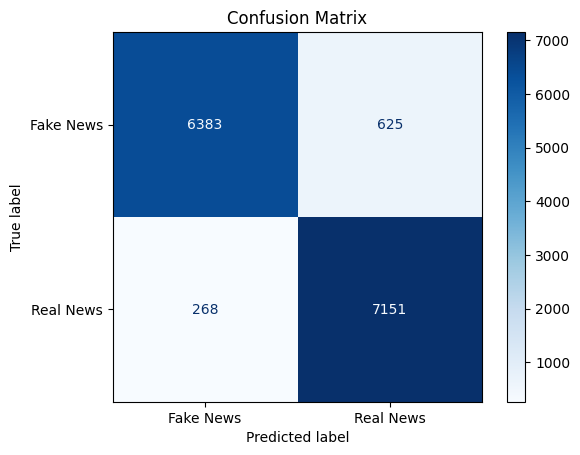

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake News", "Real News"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


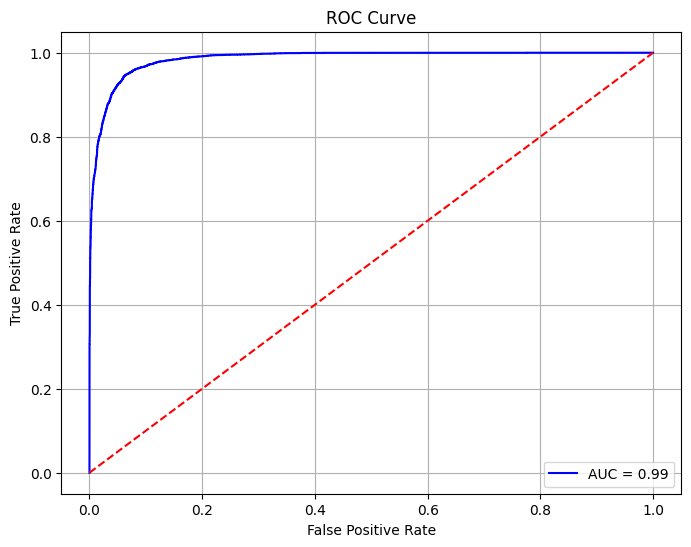

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.grid()
plt.show()
